In [1]:
import torch
import numpy as np
import os
import scipy.io
from PIL import Image
from torchvision.transforms import *
from torch.utils.data import DataLoader

def standardize_label(label, orim):  #保证了原图像的坐标的准确
    label_std = []
    for idx, _ in enumerate(label):
        labelX = label[idx][0] / orim.size[0]  #x的值除于原始图像的宽
        labelY = label[idx][1] / orim.size[1]  #y的值除于原始图像的高
        label_std.append([labelX, labelY])
    label_std = np.array(label_std)
    # print(label_std)
    return label_std

SHOW_FLAG = False
# guassian generation
def getGaussianMap(joint, heat_size, sigma):
    # by default, the function returns a gaussian map with range [0, 1] of typr float32
    heatmap = np.zeros((heat_size, heat_size), dtype=np.float32)
    tmp_size = sigma * 3
    ul = [int(joint[0] - tmp_size), int(joint[1] - tmp_size)]
    br = [int(joint[0] + tmp_size + 1), int(joint[1] + tmp_size + 1)]
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * (sigma ** 2)))
    g.shape
    # usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], heat_size) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], heat_size) - ul[1]
    # image range
    img_x = max(0, ul[0]), min(br[0], heat_size)
    img_y = max(0, ul[1]), min(br[1], heat_size)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    
    if SHOW_FLAG:
        heatmap *= 255
        heatmap = heatmap.astype(np.uint8)
        cv2.imshow("debug", heatmap)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
#         SHOW_FLAG = False
    
    return heatmap


class PoseImageDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, imagespath='', labelsfilepath=''):

        imgs_list = sorted(os.listdir(os.path.join(imagespath)))  # 获得文件夹内的图片的名称列表
        self.filenames = imgs_list

        #将注释文件加载到矩阵中
        self.annotationmat = scipy.io.loadmat(labelsfilepath)
        # print(self.annotationmat) #加载.mat文件的数据

        joints = self.annotationmat['joints']
        # print(joints) # 只加载'joints'键的数据
        # print(joints.shape) # (3, 14, 2000)

        joints = np.swapaxes(joints, 2, 0)
        """
        print(joints)
        将0轴和2轴转换，使[ 29.74645941 143.34544031   0.        ]就为第一张图片的x轴和y轴以及二进制的值
        [[[ 29.74645941 143.34544031   0.        ]
          [ 30.5501068  117.22690013   0.        ]
          [ 28.94281202  84.67918082   0.        ]
          ...
        """

        labels = []
        images = []
        self.heatmap_set = np.zeros((2000, 128, 128, 14), dtype=np.float32)

        origin_image_size = []

        for file_idx, file_name in enumerate(imgs_list):
            fn = imgs_list[file_idx]
            orim = Image.open(os.path.join(imagespath,fn))
            origin_image_size.append(orim.size)
            # print(orim)   # Image.open根据拼接的路径获取图像信息

            # print(self.transforms)
            image1 = transforms(orim)  #将图像信息归一化
            # print(image1.shape)

            label = joints[file_idx]
            # print(label)

            #standardizing标准化
            label = standardize_label(label, orim)
            # print(label)
            for j in range(14):
#                 print(label)
                _joint = (label[j, 0:2] * image_size // 2).astype(np.uint16)
#                 print(_joint)
                self.heatmap_set[file_idx, :, :, j] = getGaussianMap(joint=_joint, heat_size=128, sigma=2)
    
            label = torch.from_numpy(label)  # torch.from_numpy()方法把数组转换成张量，且二者共享内存，对张量进行修改比如重新赋值，那么原始数组也会相应发生改变。
            label1 = label.type(torch.FloatTensor)

            images.append(image1)
            labels.append(label1)

        self.images = images
        self.labels = labels
        self.orim_size = origin_image_size
        print("heatmap_set", len(self.heatmap_set))
        print("images", len(self.images))
        print("orim_size", len(self.orim_size))

    def __getitem__(self, idx):
        return self.images[idx], self.heatmap_set[idx], self.orim_size[idx]
#         return self.images[idx], self.labels[idx], self.orim_size[idx]

    def __len__(self):
        return len(self.filenames)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 优先使用显卡
print(f"using {device}")

image_path = './dataset/lsp/images'
labels_file_path = './dataset/lsp/joints.mat'
# image_size = 128
image_size = 256 # blazepose
# image_size = 196 # deeppose
batch_size = 32
transforms = Compose([
    Resize((image_size,image_size)),
    ToTensor(),  #张量化
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


dataset = PoseImageDataset(transforms, image_path, labels_file_path)
# print(dataset.images.shape)  #(2000, 14, 3)

#数据集划分
total = len(dataset)
print(total)
train_size, test_size = int(total * 0.5), int(total * 0.5)
lengths = [train_size, test_size]
train_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, lengths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

using cuda
heatmap_set 2000
images 2000
orim_size 2000
2000


3
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(128, 128)


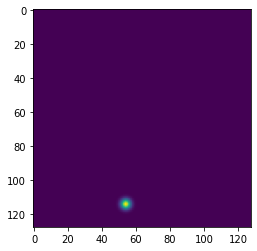

In [13]:
import matplotlib.pyplot as plt
import cv2

dataiter = iter(train_dataloader)
# print(dataiter)
print(len(dataiter.next()))
images, heatmap, int_labels = dataiter.next()
# img = images[0]
# img = img.numpy()
# img = np.transpose(img, (1, 2, 0))
# img = img[:,:,-1::]

# plt.imshow(img)

heatmap *= 255
heatmap1 = heatmap.numpy().astype(np.uint8)[0]
# print(heatmap1)
heatmap1 = heatmap1[:,:,0]
print(heatmap1)
print(heatmap1.shape)
plt.imshow(heatmap1)
# cv2.imshow("debug", heatmap1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
from BlazeModel import BlazePose

model = BlazePose(14).to(device)
print(model)

BlazePose(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): h_swish(
      (sigmoid): h_sigmoid()
    )
  )
  (conv2_b1): MobileBottleneck(
    (conv): Sequential(
      (0): Conv2d(16, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
      (4): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Identity()
      (6): ReLU6(inplace=True)
      (7): Conv2d(72, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3_b1): MobileBottleneck(
    (conv): Sequential(
      (0)

In [2]:
model = torch.load("BlazePose.model").to(device)
print(model)

BlazePose(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): h_swish(
      (sigmoid): h_sigmoid()
    )
  )
  (conv2_b1): MobileBottleneck(
    (conv): Sequential(
      (0): Conv2d(16, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
      (4): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Identity()
      (6): ReLU6(inplace=True)
      (7): Conv2d(72, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3_b1): MobileBottleneck(
    (conv): Sequential(
      (0)

In [3]:
def train():
#     model.train()
    loss_value = 0
    for tmp, (images, labels, _) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  #方便用于gpu
        
        predict = model(images)  # 把图像数据放进model里
#         print(predict.shape)
#         print(labels.shape)
        
        predict = predict.view(labels.shape)

        loss_value = lossFunction(predict, labels)  # 将标签和图像数据同时放入

        # 反向传播
        optimizer.zero_grad()  # 梯度置零，也就是把loss关于weight的导数变成0.
        loss_value.backward()
        optimizer.step()

        if tmp > 0:
            if (tmp % 10) == 0:
#                 print('checkpoint guardado' + str(tmp))
                torch.save(model.state_dict(), './chpcurrent_HourGlass.chp')

    return loss_value.item()

def test():
#     model.eval()
    test_loss_total = 0

    images_accuracy = []
    
    with torch.no_grad():
        for images, labels, orim_size in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            predict = model(images)  # 把图像数据放进model里

            predict = predict.view(labels.shape)  #将预测的关节点坐标整理成原始坐标的形状

#             for idx, _ in enumerate(labels):
#                 print(predict[idx], labels[idx])
#                 image_accuracy = accuracy_compute(predict[idx], labels[idx], image_size)
#                 images_accuracy.append(image_accuracy)

            loss_value = lossFunction(predict, labels)  # 将标签和图像数据同时放入

            test_loss_total += loss_value


#         accuracy = sum(images_accuracy) / len(images_accuracy)  #batch的准确率
        test_loss_total /= len(test_dataset)

#         print("准确率：", accuracy)
        return test_loss_total


def accuracy_compute(predict, labels, img_size, deviation_distance = 5):
    #处理一个图片的准确率
    joints = 14
    correct = 0  #正确的个数

    for idx, _ in enumerate(labels):
        # print(predict[idx] * img_size, labels[idx] * img_size)
        deviation = ((predict[idx] - labels[idx]) * img_size) ** 2  #使用距离公式
        deviation = sum(deviation)
        # print(deviation)
        # print(deviation_distance ** 2)

        if deviation <= deviation_distance ** 2:
            correct += 1

    accuary = correct / joints

    return accuary

In [21]:
test_loss, accuracy = [], []

lossFunction = torch.nn.MSELoss(reduction='sum')  #均方差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # 优化器 0.00001

EPOCHS = 500
# 批训练EPOCHS
for epoch in range(1, EPOCHS+1):

    train_loss = train()  #训练

    test_loss_= test()   #测试
    print(f"第{epoch}/{EPOCHS}次训练，训练损失值为{train_loss}, 测试损失值为{test_loss_}")

    test_loss1 = test_loss_.detach().cpu().numpy()
    test_loss.append(test_loss1)
#     accuracy.append(accuracy_)

model_name = "BlazePose"
torch.save(model, model_name + ".model")

第1/500次训练，训练损失值为1381.3125, 测试损失值为176.16761779785156
第2/500次训练，训练损失值为1381.490966796875, 测试损失值为176.15103149414062
第3/500次训练，训练损失值为1383.9822998046875, 测试损失值为176.1826171875
第4/500次训练，训练损失值为1385.38037109375, 测试损失值为176.18814086914062
第5/500次训练，训练损失值为1379.765869140625, 测试损失值为176.19140625
第6/500次训练，训练损失值为1388.098388671875, 测试损失值为176.1631622314453
第7/500次训练，训练损失值为1380.07763671875, 测试损失值为176.18435668945312
第8/500次训练，训练损失值为1388.0634765625, 测试损失值为176.1847381591797
第9/500次训练，训练损失值为1384.597900390625, 测试损失值为176.163818359375
第10/500次训练，训练损失值为1387.9425048828125, 测试损失值为176.15830993652344
第11/500次训练，训练损失值为1380.586181640625, 测试损失值为176.1898651123047
第12/500次训练，训练损失值为1381.1951904296875, 测试损失值为176.17630004882812
第13/500次训练，训练损失值为1378.170654296875, 测试损失值为176.2158966064453
第14/500次训练，训练损失值为1382.498779296875, 测试损失值为176.1473388671875
第15/500次训练，训练损失值为1387.794677734375, 测试损失值为176.1698760986328
第16/500次训练，训练损失值为1375.13623046875, 测试损失值为176.18067932128906
第17/500次训练，训练损失值为1377.64013671875, 测试损失值为176.15769958496094
第

第137/500次训练，训练损失值为1386.9013671875, 测试损失值为176.2399139404297
第138/500次训练，训练损失值为1382.8212890625, 测试损失值为176.23867797851562
第139/500次训练，训练损失值为1380.8858642578125, 测试损失值为176.2298583984375
第140/500次训练，训练损失值为1388.72998046875, 测试损失值为176.23878479003906
第141/500次训练，训练损失值为1378.939697265625, 测试损失值为176.2322540283203
第142/500次训练，训练损失值为1379.10400390625, 测试损失值为176.23007202148438
第143/500次训练，训练损失值为1384.2183837890625, 测试损失值为176.24559020996094
第144/500次训练，训练损失值为1378.7320556640625, 测试损失值为176.23898315429688
第145/500次训练，训练损失值为1390.571044921875, 测试损失值为176.24668884277344
第146/500次训练，训练损失值为1384.5426025390625, 测试损失值为176.22711181640625
第147/500次训练，训练损失值为1381.68359375, 测试损失值为176.24700927734375
第148/500次训练，训练损失值为1383.325927734375, 测试损失值为176.26226806640625
第149/500次训练，训练损失值为1385.30126953125, 测试损失值为176.23265075683594
第150/500次训练，训练损失值为1379.9935302734375, 测试损失值为176.22320556640625
第151/500次训练，训练损失值为1377.657470703125, 测试损失值为176.2667236328125
第152/500次训练，训练损失值为1391.391845703125, 测试损失值为176.25344848632812
第153/500次训练，训练损失值为

第272/500次训练，训练损失值为1383.609619140625, 测试损失值为176.30963134765625
第273/500次训练，训练损失值为1383.0751953125, 测试损失值为176.31228637695312
第274/500次训练，训练损失值为1381.49951171875, 测试损失值为176.3135223388672
第275/500次训练，训练损失值为1385.1693115234375, 测试损失值为176.3443145751953
第276/500次训练，训练损失值为1384.6163330078125, 测试损失值为176.3339080810547
第277/500次训练，训练损失值为1375.954833984375, 测试损失值为176.31256103515625
第278/500次训练，训练损失值为1377.3929443359375, 测试损失值为176.29676818847656
第279/500次训练，训练损失值为1391.3731689453125, 测试损失值为176.28858947753906
第280/500次训练，训练损失值为1370.775390625, 测试损失值为176.3295135498047
第281/500次训练，训练损失值为1391.85107421875, 测试损失值为176.33773803710938
第282/500次训练，训练损失值为1387.24365234375, 测试损失值为176.2926483154297
第283/500次训练，训练损失值为1379.1768798828125, 测试损失值为176.30712890625
第284/500次训练，训练损失值为1379.7314453125, 测试损失值为176.33090209960938
第285/500次训练，训练损失值为1389.2733154296875, 测试损失值为176.3395233154297
第286/500次训练，训练损失值为1383.563232421875, 测试损失值为176.33108520507812
第287/500次训练，训练损失值为1391.7734375, 测试损失值为176.28672790527344
第288/500次训练，训练损失值为1373.965

第406/500次训练，训练损失值为1375.7479248046875, 测试损失值为176.39398193359375
第407/500次训练，训练损失值为1375.440673828125, 测试损失值为176.39097595214844
第408/500次训练，训练损失值为1380.2821044921875, 测试损失值为176.39024353027344
第409/500次训练，训练损失值为1381.462890625, 测试损失值为176.4020538330078
第410/500次训练，训练损失值为1386.011474609375, 测试损失值为176.40206909179688
第411/500次训练，训练损失值为1372.205078125, 测试损失值为176.37188720703125
第412/500次训练，训练损失值为1368.7232666015625, 测试损失值为176.39244079589844
第413/500次训练，训练损失值为1383.40576171875, 测试损失值为176.383056640625
第414/500次训练，训练损失值为1380.108154296875, 测试损失值为176.396484375
第415/500次训练，训练损失值为1385.130859375, 测试损失值为176.39930725097656
第416/500次训练，训练损失值为1380.929931640625, 测试损失值为176.40013122558594
第417/500次训练，训练损失值为1376.48388671875, 测试损失值为176.357421875
第418/500次训练，训练损失值为1379.330322265625, 测试损失值为176.39491271972656
第419/500次训练，训练损失值为1382.693115234375, 测试损失值为176.37974548339844
第420/500次训练，训练损失值为1379.41552734375, 测试损失值为176.39093017578125
第421/500次训练，训练损失值为1381.4451904296875, 测试损失值为176.40240478515625
第422/500次训练，训练损失值为1377.902099

torch.Size([1, 14, 128, 128])


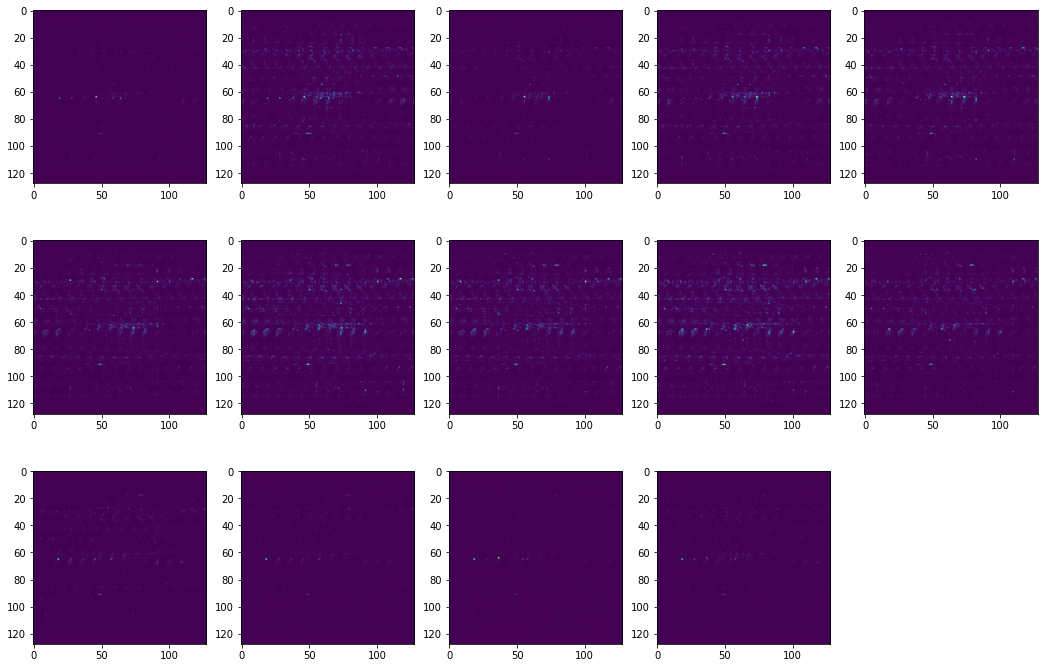

In [24]:
import matplotlib.pyplot as plt
from torch.autograd import Variable

sample_idx = 2 # 第几张照片
imgs_list = os.listdir(os.path.join(image_path))
orim = Image.open(os.path.join(image_path, imgs_list[sample_idx - 1]))

image1 = transforms(orim)
image1 = Variable(torch.unsqueeze(image1, dim=0).float(), requires_grad=False)

image = image1.to(device)
predict = model(image)
print(predict.shape)
predict_ = predict.view((128, 128, 14)).cpu().detach().numpy()

fig = plt.figure(figsize=(18, 12))
for i in range(14):
    ax1 = fig.add_subplot(3, 5, i+1)
    img = predict_[:,:,i]
    ax1.imshow(img)
plt.show()